In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import *

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library.standard_gates import XGate
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
sim = AerSimulator()

from util import zero, one

# QI: Quantum Error Correction

Throughout this series of notebooks, we have assumed **logical qubits**, i.e., qubits without errors. However, the qubits we have today cannot be controlled perfectly and thus have errors. These are called **physical qubits**.
2. We'll first look at sources of error in a single qubit.
3. Then, we'll look at how to use **quantum error correction** (**QEC**) to turn physical qubits into logical qubits. Specifically, we'll look at the **bit-flip code**.

References
1. [Introduction to Classical and
Quantum Computing, Chapter 4.7](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf)

## Sources of Error

Recall a single qubit.

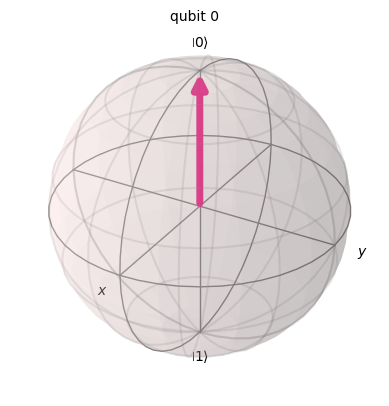

In [2]:
plot_bloch_multivector(zero)

### YZ-Error or Bit-Flip Error

1. Instead of having a logical $|0\rangle$, we may have a perturbed $|0\rangle$ that is off in the $YZ$ plane (rotation about x-axis) by a small angle.
2. In this example, consider throwing off the $|0\rangle$ by a $\pi/20$ angle.

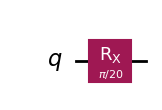

In [3]:
qc_yz_err = QuantumCircuit(1)
qc_yz_err.rx(np.pi/20, 0)
qc_yz_err.draw(output="mpl", style="iqp")

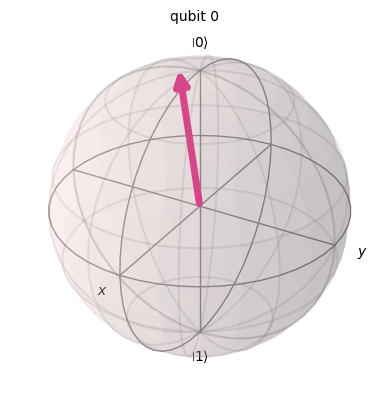

In [4]:
plot_bloch_multivector(zero.evolve(Operator(qc_yz_err)))

#### How bad is the error?

We can compute the quantum state and compute the probability of measuring a $|0\rangle$.

In [5]:
zero.evolve(Operator(qc_yz_err)).draw("latex")

<IPython.core.display.Latex object>

In [6]:
# Probability of measuring a |0>
0.9969173337**2

0.9938441702315172

#### As a histogram

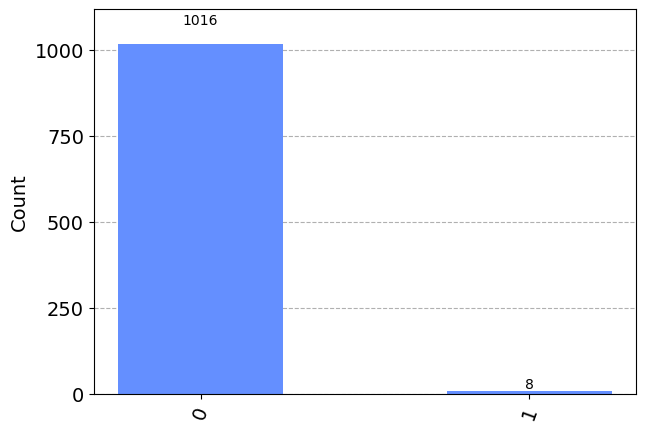

In [7]:
qc = QuantumCircuit(1, 1)
qc.rx(np.pi/20, 0)        
qc.measure(0, 0)
results = sim.run(qc, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

#### How small is small?

1. You might think that $0.9938441702315172$ is quite a high probability.
2. Let's plot the number of successive operations we can perform and the probability of success without error.
3. For comparison, your classical computer can effectively run billions of operations without errors every second.

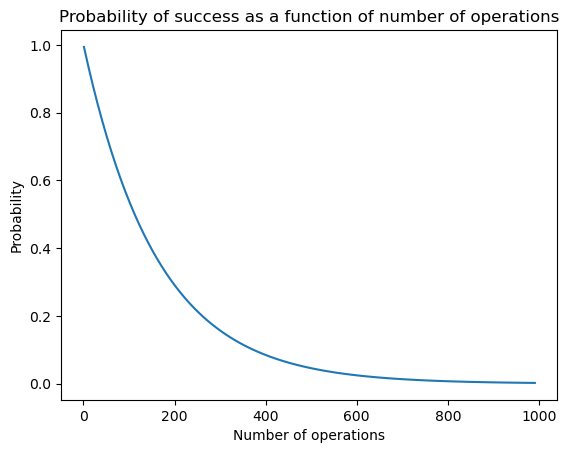

In [8]:
p = 0.9938441702315172
num_ops = range(1, 1000, 10)
prob_err = [p**x for x in num_ops]
plt.plot(num_ops, prob_err)
plt.title("Probability of success as a function of number of operations")
plt.ylabel("Probability");
plt.xlabel("Number of operations");

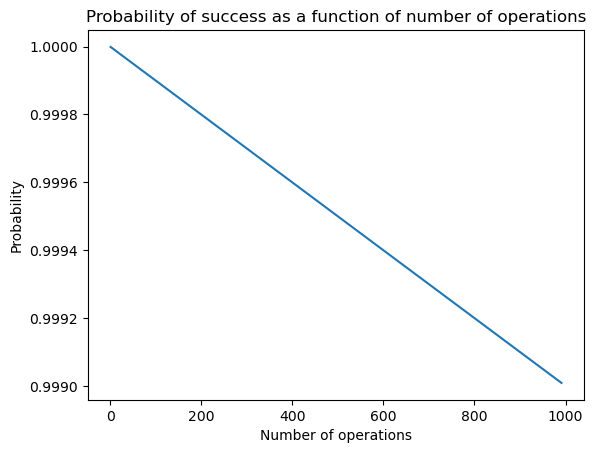

In [9]:
p = 0.999999  # Improving the error rate
num_ops = range(1, 1000, 10)
prob_err = [p**x for x in num_ops]
plt.plot(num_ops, prob_err)
plt.title("Probability of success as a function of number of operations")
plt.ylabel("Probability");
plt.xlabel("Number of operations");

In [10]:
qc_yz_err2 = QuantumCircuit(1)
qc_yz_err2.rx(np.pi/1800, 0)
zero.evolve(Operator(qc_yz_err2)).draw("latex")

<IPython.core.display.Latex object>

In [11]:
0.9999996192**2

0.999999238400145

In [12]:
# Your qubit needs to be accurate to within 0.1 degrees in order
# to perform 1000 operations with probability 0.999 of success
print("Angle in degrees", np.pi/1800*(180/np.pi))

Angle in degrees 0.1


### XY-Error or Phase-Flip Error

1. Unlike classical error correction where we can only flip a $0$ to a $1$, or vice versa, we also have **phase-flip** errors.
2. This is perturbation of a quantum state in the $XY$-plane, i.e., rotation about the Z-axis in the Bloch sphere.
3. Consider throwing off the $H|0\rangle$ by a $\pi/20$ angle in the $XY$ plane. We are using $H|0\rangle$ since rotation of $|0\rangle$ in the z-axis.

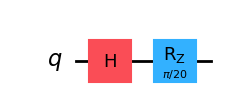

In [13]:
qc_xy_err = QuantumCircuit(1)
qc_xy_err.h(0)
qc_xy_err.rz(np.pi/20, 0)
qc_xy_err.draw(output="mpl", style="iqp")

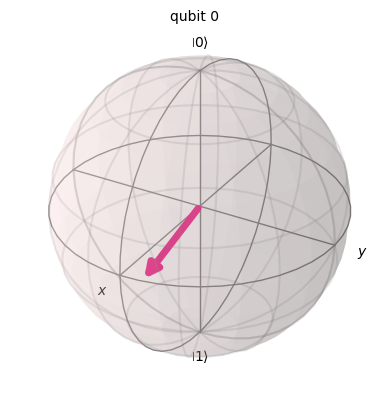

In [14]:
plot_bloch_multivector(zero.evolve(Operator(qc_xy_err)))

In [15]:
zero.evolve(Operator(qc_xy_err)).draw("latex")

<IPython.core.display.Latex object>

In [16]:
# Probability of measuring a |0>
np.abs(0.704927007 - 0.0554789586*1j)**2

0.5000000000453186

#### Discusion question

Is it possible to measure the error in this qubit? How would we be able to tell that there is an error in this qubit?

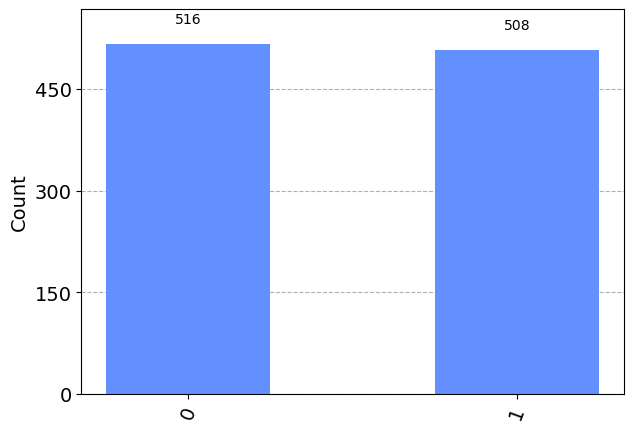

In [17]:
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.rz(np.pi/20, 0)        
qc.measure(0, 0)
results = sim.run(qc, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

### Bit-Flip Error and Phase-Flip Error

A single qubit can exhibit both bit-flip and phase-flip errors.

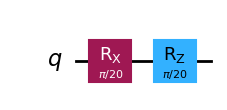

In [18]:
qc_err = QuantumCircuit(1)
qc_err.rx(np.pi/20, 0)
qc_err.rz(np.pi/20, 0)
qc_err.draw(output="mpl", style="iqp")

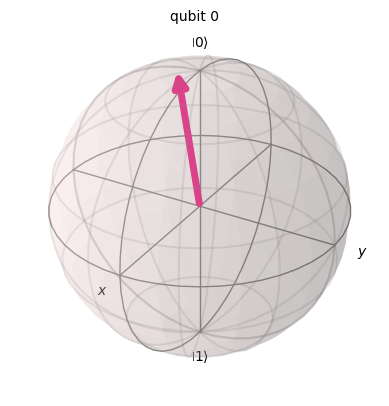

In [19]:
plot_bloch_multivector(zero.evolve(Operator(qc_err)))

In [20]:
zero.evolve(Operator(qc_err)).draw("latex")

<IPython.core.display.Latex object>

In [21]:
np.abs(0.9938441703 - 0.0782172325*1j)**2

0.9938441702992548

#### Histogram

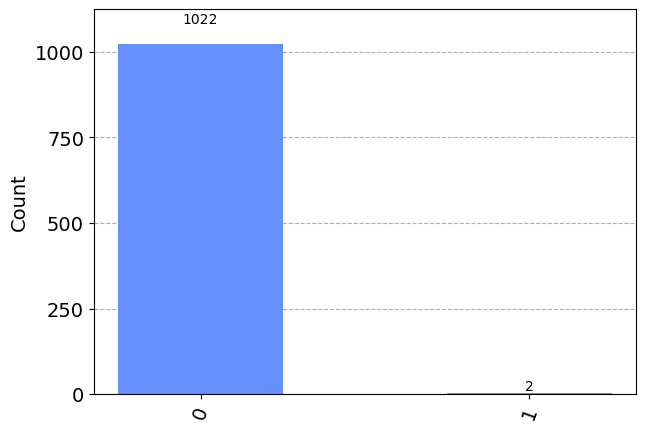

In [22]:
qc = QuantumCircuit(1, 1)
qc.rx(np.pi/20, 0)        
qc.measure(0, 0)
results = sim.run(qc, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

## Error Correction Strategy

1. Introduce **Bit-Flip Code** which corrects errors in the YZ plane of the Bloch sphere.
2. The **Phase-Flip Code** which corrects errors in the XY plane of the Bloch sphere is similar to the Bit-Flip code.
3. **Shor's Code** combines the Bit-Flip Code and Phase-Flip Code to correct both flip and phase errors.

## Bit-Flip Code

In the Bit-Flip Code,  we will use three physical qubits to encode one logical qubit.
1. Logical $|0_L\rangle$ is defined as

$$
|0_L\rangle = |000\rangle \,.
$$

2. Logical $|1_L\rangle$ is defined as

$$
|1_L\rangle = |111\rangle \,.
$$

3. Thus any logical qubit can be defined as

$$
\alpha|0_L\rangle + \beta|1_L\rangle \,.
$$

### Example: Entire Qubit Flipped

1. Suppose we have a qubit

$$
|\psi\rangle = \alpha|0_L\rangle + \beta|1_L\rangle
$$

where one of the underlying qubits becomes corrupted. For example,

$$
\alpha|000\rangle + \beta|111\rangle \rightarrow \alpha|100\rangle + \beta|011\rangle
$$

so that the most-significant physical qubit becomes flipped.

2. Intuitively, our error-correction scheme is: predict the majority of a qubit in a group since flipping two $|0\rangle$'s to $|1\rangle$'s is less likely than flipping a single one.

3. However, how do we do this without measuring the qubit since doing so would destroy the state of superposition?

### Majority Error-Correcting Code

1. Suppose we have $|b_2 b_1 b_0\rangle$.
2. We want $|001\rangle$, $|010\rangle$, and $|100\rangle$ to be corrected to $|000\rangle$.
3. Similarly we want $|110\rangle$, $|101\rangle$, and $|011\rangle$ to be corrected to $|111\rangle$.

### Parity and Majority Error-Correcting Code

We can accomplish this by computing the parity of adjacent bits $b_2 \oplus b_1$ and $b_1 \oplus b_0$.

| Codeword | b2 XOR b1 | b1 XOR b0 |
|--------- | --------------   | ---------------- |
| 000      |         0        |         0        |    
| 001      |         0        |         1        |
| 010      |         1        |         1        |
| 011      |         1        |         0        |
| 100      |         1        |         0        |    
| 101      |         1        |         1        |
| 110      |         0        |         1        |
| 111      |         0        |         0        |

1. Parity of $00$ means no error (either $|000\rangle$ or $|111\rangle$).
2. Parity of $01$ means $b_0$ flipped (either $|001\rangle$ or $|110\rangle$).
3. Parity of $10$ means $b_2$ flipped (either $|011\rangle$ or $|100\rangle$).
4. Parity of $11$ means $b_1$ flipped (either $|010\rangle$ or $|101\rangle$).

Crucially, we do not need to know the codeword! This means we can implement it in a quantum setting without measurement.

### Quantum Parity and Majority Error-Correcting Code

Recall the CNOT gate calculates an XOR.

$$
CNOT|b_1 b_0\rangle = CNOT|b_1 (b_1 \oplus b_0)\rangle
$$

We would thus like to construct a circuit $U$ such that 

$$
U_\text{parity}|q_4 q_3 q_2 q_1 q_0\rangle = |(q_2 \oplus q_1) (q_1 \oplus q_0) q_2 q_1 q_0\rangle \,.
$$

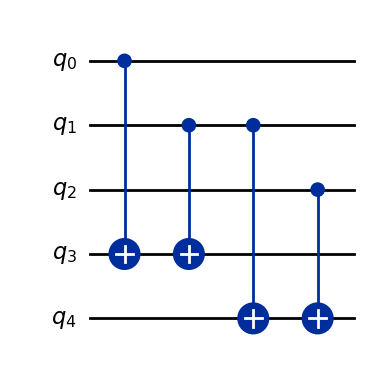

In [23]:
qc_parity = QuantumCircuit(5)
qc_parity.cx(0, 3); qc_parity.cx(1, 3)  # Compute |q_3> = |q_1 XOR q_0>
qc_parity.cx(1, 4); qc_parity.cx(2, 4)  # Compute |q_4> = |q_2 XOR q_1>
qc_parity.draw(output="mpl", style="iqp")

In [24]:
# |q_3 q_3 q_2 q_1 q_0>
# |q_2 q_1 q_0> = |000>
# |q_4 q_3> = |(q_2 XOR q_1) (q_1 XOR q_0)> = 00
# This means there are no errors
(zero ^ zero ^ zero ^ zero ^ zero).evolve(Operator(qc_parity)).draw("latex")

<IPython.core.display.Latex object>

In [25]:
# |q_3 q_3 q_2 q_1 q_0>
# |q_2 q_1 q_0> = |010>
# |q_4 q_3> = |(q_2 XOR q_1) (q_1 XOR q_0)> = 11
# Parity of 11 means q_1 flipped (either |010> or |101>).
(zero ^ zero ^ zero ^ one ^ zero).evolve(Operator(qc_parity)).draw("latex")

<IPython.core.display.Latex object>

In [26]:
# |q_3 q_3 q_2 q_1 q_0>
# |q_2 q_1 q_0> = |011>
# |q_4 q_3> = |(q_2 XOR q_1) (q_1 XOR q_0)> = 10
# Parity of 10 means q_2 flipped (either |011> or |100>).
(zero ^ zero ^ zero ^ one ^ one).evolve(Operator(qc_parity)).draw("latex")

<IPython.core.display.Latex object>

### Correcting the parity

1. Recall that a parity of $11$ means $q_1$ flipped (either $|010\rangle$ or $|101\rangle$).
Thus we need a circuit

$$
U_{11}|11q_2 q_1 q_0\rangle = U_{11}|11q_2 (X q_1) q_0\rangle \,.
$$

2. Recall that a parity of $10$ means $q_2$ flipped (either $|011\rangle$ or $|100\rangle$).
Thus we need a circuit

$$
U_{10}|10q_2 q_1 q_0\rangle = U_{10}|11(X q_2) q_1 q_0\rangle \,.
$$ 

3. Finally recall that a parity of $01$ means that $q_0$ flipped (either $|001\rangle$ or $|110\rangle$).
Thus we need a circuit

$$
U_{01}|01q_2 q_1 q_0\rangle = U_{01}|11 q_2 q_1 (X q_0) \rangle \,.
$$ 

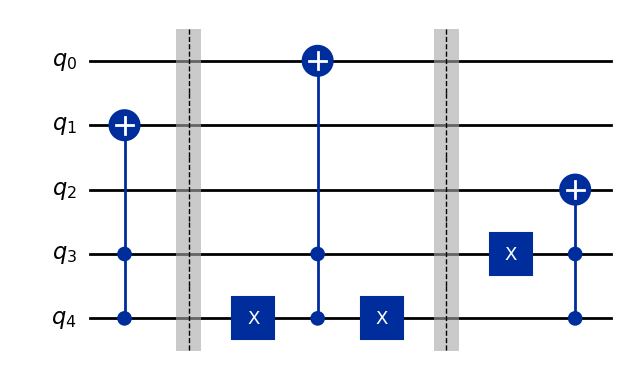

In [27]:
qc_fix = QuantumCircuit(5)
qc_fix.append(XGate().control(2), [3, 4, 1])                  # |11> -> flip q_1
qc_fix.barrier()
qc_fix.x(4); qc_fix.append(XGate().control(2), [3, 4, 0]); qc_fix.x(4)     # |10> -> flip q_0
qc_fix.barrier()
qc_fix.x(3); qc_fix.append(XGate().control(2), [3, 4, 2])     # |01> -> flip q_2
qc_fix.draw(output="mpl", style="iqp")

### Putting it together

In [28]:
def create(q_2, q_1, q_0):
    qc = QuantumCircuit(5, 5)
    qc.initialize(q_0, 0); qc.initialize(q_1, 1); qc.initialize(q_2, 2);
    qc.barrier()
    
    # Compute parity
    qc.cx(0, 3); qc.cx(1, 3)   # Compute |q_3> = |q_1 XOR q_0>
    qc.cx(1, 4); qc.cx(2, 4)   # Compute |q_4> = |q_2 XOR q_1>
    qc.barrier()
    qc.measure(3, 3); qc.measure(4, 4)
    qc.barrier()
    
    # Fix parity
    qc.append(XGate().control(2), [3, 4, 1])              # |11> -> flip q_1
    qc.barrier()
    qc.x(4); qc.append(XGate().control(2), [3, 4, 0]); qc.x(4)     # |10> -> flip q_0
    qc.barrier()
    qc.x(3); qc.append(XGate().control(2), [3, 4, 2])     # |01> -> flip q_2
    qc.barrier()
    
    # Reinitialize for further error correction
    qc.initialize(zero, 3)
    qc.initialize(zero, 4)
    
    # Readout
    qc.measure(0, 0); qc.measure(1, 1); qc.measure(2, 2)  # Measure result
    return qc

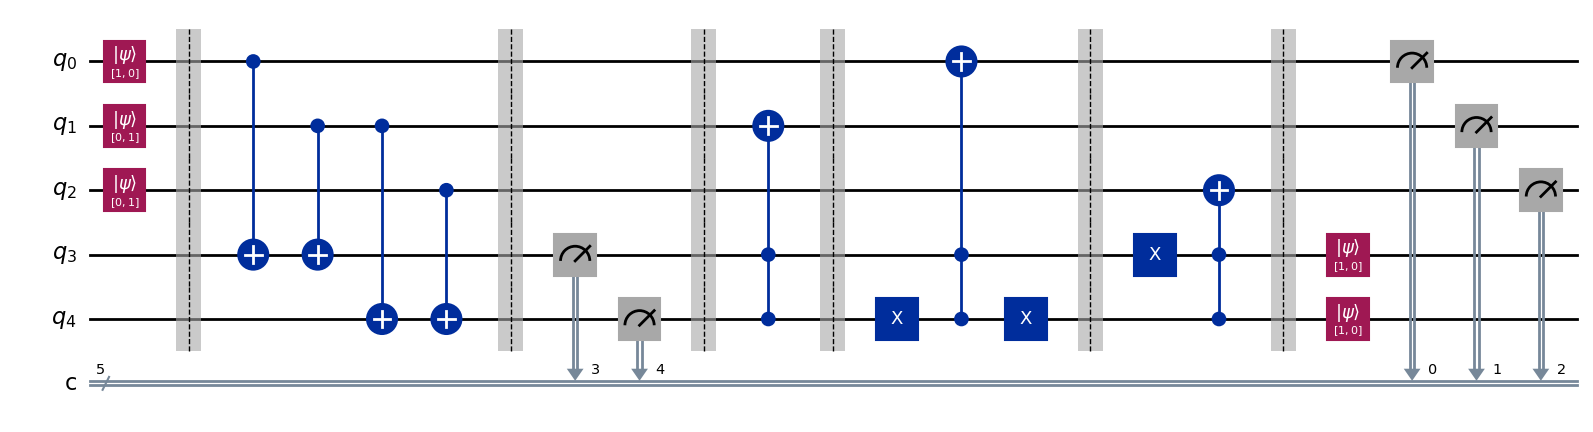

In [29]:
qc = create(one, one, zero)
qc.draw(output="mpl", style="iqp")

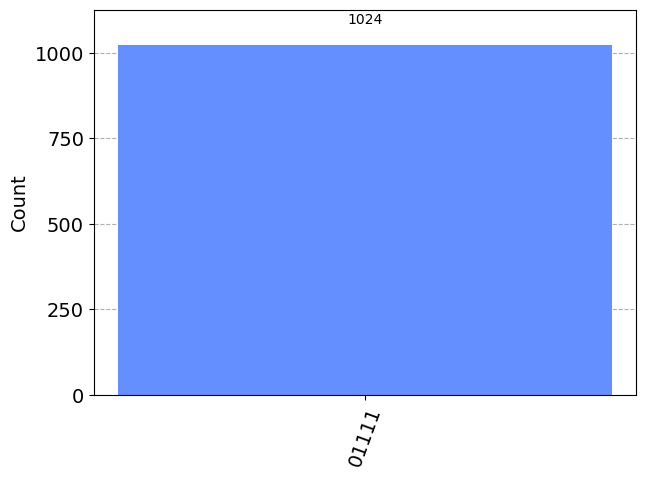

In [30]:
results = sim.run(qc, shots=1024).result()
answer = results.get_counts()
# Note that |01111> = |01> \oplus |111> so that |110> got corrected to |111>
plot_histogram(answer)

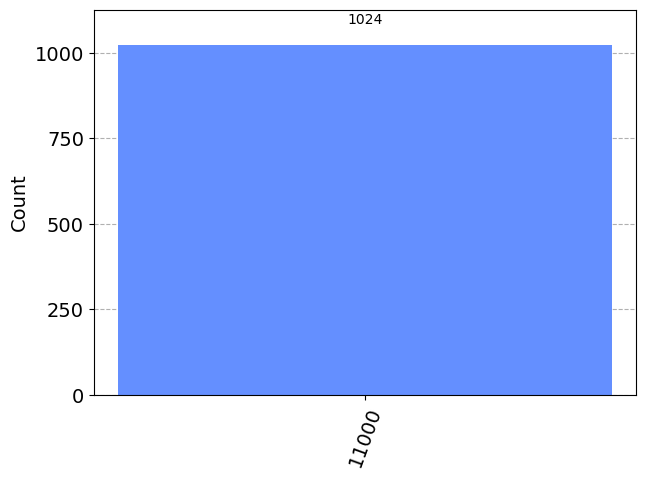

In [31]:
qc = create(zero, one, zero)
results = sim.run(qc, shots=1024).result()
answer = results.get_counts()
# Note that |11000> = |11> \oplus |000> so that |010> got corrected to |000>
plot_histogram(answer)

### What about partial errors?

Suppose we corrupt a qubit by a rotation of $\theta$ about the x-axis ($YZ$ plane). This corresponds to using the $R_x(\theta)$ gate.

$$
R_x(\theta) = 
\begin{pmatrix}
\cos(\theta/2) & -i\sin(\theta/2) \\
-i\sin(\theta/2) & \cos(\theta/2)
\end{pmatrix}
$$

Reparameterizing as $\epsilon = \sin (\theta/2)$, we obtain

$$
U_\epsilon = \begin{pmatrix}
\sqrt{1 - \epsilon^2} & -i \epsilon \\
-i \epsilon & \sqrt{1 - \epsilon^2}
\end{pmatrix} \,.
$$

### Example: suppose most-significant qubit is corrupted

This produces a physical qubit in state

\begin{align}
(U_\epsilon \otimes I \otimes I)(\alpha|000\rangle + \beta|111\rangle) & = \alpha (\sqrt{1 - \epsilon^2}|000\rangle -i \epsilon |100\rangle) + \beta (\sqrt{1 - \epsilon^2}|111\rangle - i\epsilon|011\rangle) \\
& = \alpha\sqrt{1 - \epsilon^2}|000\rangle - i\alpha\epsilon|100\rangle + \beta\sqrt{1 - \epsilon^2}|111\rangle - i\beta\epsilon|011\rangle \,.
\end{align}

1. $parity(q_2, q_1) = 0$ and $parity(q_1, q_0) = 0$ occurs with the state

$$
\alpha\sqrt{1 - \epsilon^2}|000\rangle + \beta\sqrt{1 - \epsilon^2}|111\rangle \,.
$$

This occurs with probability $|\alpha\sqrt{1 - \epsilon^2}|^2 + |\beta\sqrt{1 - \epsilon^2}|^2 = 1 - \epsilon^2$. Thus, with probability $1 - \epsilon^2$, we do not need to do anything.

2. $parity(q_2, q_1) = 1$ and $parity(q_1, q_0) = 0$ occurs with the state

$$
-i\beta\epsilon|011\rangle - i\alpha\epsilon|100\rangle \,.
$$

This occurs with probability $|-i\beta\epsilon|^2 + |-i\alpha\epsilon|^2 = \epsilon^2$. Thus, with probability $\epsilon^2$, we should apply an $X$ gate to the most-significant qubit.

3. The reasoning for partial flips on the middle and least significant qubit is similar.

4. Thus this procedure is exactly the same as the complete flip case.

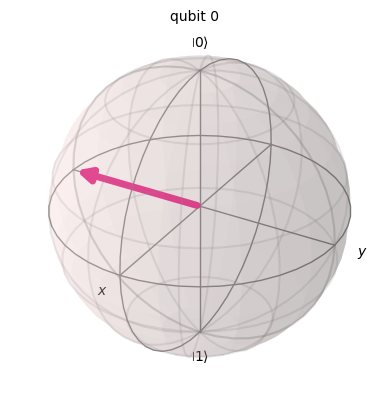

In [32]:
def corrupt(angle, q):
    qc_err = QuantumCircuit(1)
    # qc_err.p(np.pi, 0)
    qc_err.rx(angle * np.pi/180, 0)
    return q.evolve(Operator(qc_err))

plot_bloch_multivector(corrupt(90, zero))

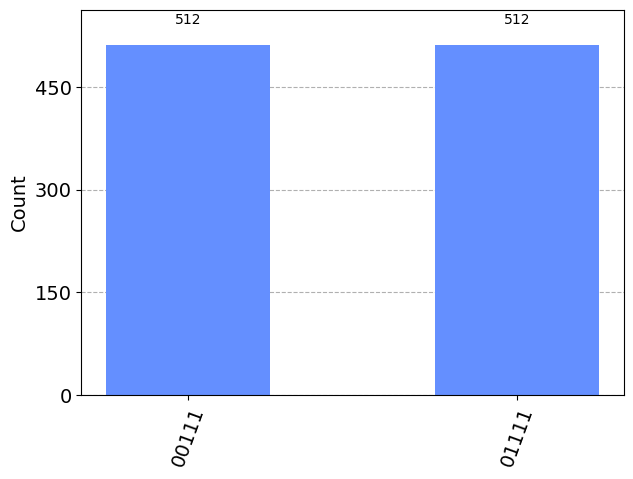

In [33]:
qc = create(one, one, corrupt(90, one))
results = sim.run(qc, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

## Summary

1. We saw the basics of quantum error correction based on bit-flip code.
2. The bit-flip code encodes 1 logical qubit with 3 physical qubits. 2 ancila (additional) qubits in addition to mid-circuit measurement were needed to complete the code.
3. Correcting bit-flips and phase-flips together can be done with Shor's code (see [Introduction to Classical and
Quantum Computing, Chapter 4.7](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf) for more details)
4. It is an active area of research of how to develop better quantum error correcting codes that have lower overhead or can correct different kinds of errors.
5. Logical qubits are required to implement Grover's search and Shor's algorithm